# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.466372,False,1.487627
1,-0.704426,True,3.306835
2,-1.497792,False,-2.467635
3,0.045241,False,0.505998
4,-0.189657,False,0.450247
...,...,...,...
995,-2.232604,True,4.413348
996,0.206981,True,7.418781
997,-0.923973,False,-1.571704
998,-3.088508,False,-3.508877


<AxesSubplot: xlabel='v0'>

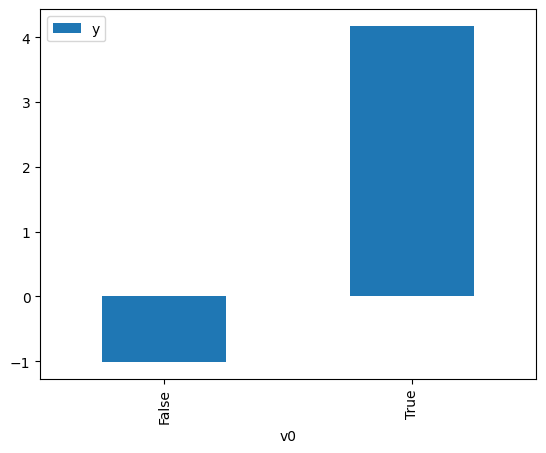

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

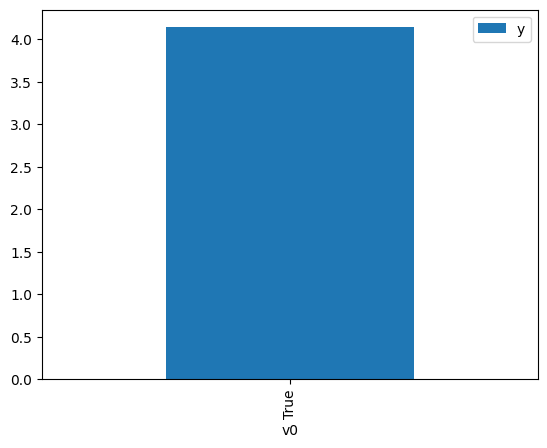

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-2.524005,False,-6.193919,0.905670,1.104155
1,0.337514,False,1.111026,0.453566,2.204750
2,-1.643986,False,-1.899768,0.818911,1.221134
3,-1.167004,False,-2.787843,0.750430,1.332569
4,-1.938610,False,-0.744513,0.853341,1.171864
...,...,...,...,...,...
995,0.959606,False,-0.958200,0.327724,3.051350
996,-2.073384,False,-2.769339,0.867192,1.153147
997,-0.932008,False,-0.663544,0.710920,1.406627
998,0.218917,False,1.814552,0.478811,2.088507


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.210825,True,1.819430,0.242615,4.121764
1,-0.848285,True,5.682561,0.304020,3.289262
2,-2.295197,True,2.644286,0.112433,8.894172
3,-1.759628,True,2.805313,0.166877,5.992430
4,-0.776731,True,2.894867,0.317126,3.153323
...,...,...,...,...,...
995,-1.567087,True,3.480768,0.191051,5.234206
996,-1.426197,True,4.042869,0.210376,4.753386
997,-0.136342,True,5.505401,0.445435,2.244996
998,-1.674413,True,3.389337,0.177261,5.641409


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.896
Method:                 Least Squares   F-statistic:                              4309.
Date:                Mon, 14 Nov 2022   Prob (F-statistic):                        0.00
Time:                        20:37:57   Log-Likelihood:                         -1424.2
No. Observations:                1000   AIC:                                      2852.
Df Residuals:                     998   BIC:                                      2862.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0321      0.024     43.886      0.000       0.986       1.078
x2             5.0583      0.058     87.970      0.000       4.945       5.171
==============================================================================
Omnibus:                        0.464   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.793   Jarque-Bera (JB):                0.544
Skew:                          -0.039   Prob(JB):                        0.762
Kurtosis:                       2.917   Cond. No.                         2.49
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""